In [5]:
import argparse
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from utils.data_loading import BasicDataset
from unet.unet_model_rt import UNet
from utils.utils import plot_img_and_mask




def get_args():
    parser = argparse.ArgumentParser(description='Predict masks from input images')
    parser.add_argument('--model', '-m', default='MODEL.pth', metavar='FILE',
                        help='Specify the file in which the model is stored')
    parser.add_argument('--input', '-i', metavar='INPUT', nargs='+', help='Filenames of input images', required=True)
    parser.add_argument('--output', '-o', metavar='OUTPUT', nargs='+', help='Filenames of output images')
    parser.add_argument('--viz', '-v', action='store_true',
                        help='Visualize the images as they are processed')
    parser.add_argument('--no-save', '-n', action='store_true', help='Do not save the output masks')
    parser.add_argument('--mask-threshold', '-t', type=float, default=0.5,
                        help='Minimum probability value to consider a mask pixel white')
    parser.add_argument('--scale', '-s', type=float, default=0.5,
                        help='Scale factor for the input images')
    parser.add_argument('--bilinear', action='store_true', default=False, help='Use bilinear upsampling')
    parser.add_argument('--classes', '-c', type=int, default=2, help='Number of classes')

    return parser.parse_args()


def get_output_filenames(args):
    def _generate_name(fn):
        return f'{os.path.splitext(fn)[0]}_OUT.png'

    return args.output or list(map(_generate_name, args.input))


def mask_to_image(mask: np.ndarray, mask_values):
    if isinstance(mask_values[0], list):
        out = np.zeros((mask.shape[-2], mask.shape[-1], len(mask_values[0])), dtype=np.uint8)
    elif mask_values == [0, 1]:
        out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=bool)
    else:
        out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=np.uint8)

    if mask.ndim == 3:
        mask = np.argmax(mask, axis=0)

    for i, v in enumerate(mask_values):
        out[mask == i] = v

    return Image.fromarray(out)


if __name__ == '__main__':
    args = get_args()
    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

    in_files = args.input
    out_files = get_output_filenames(args)

    net = UNet(n_channels=3, n_classes=args.classes, bilinear=args.bilinear)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f'Loading model {args.model}')
    logging.info(f'Using device {device}')

    net.to(device=device)
    state_dict = torch.load(args.model, map_location=device)
    mask_values = state_dict.pop('mask_values', [0, 1])
    net.load_state_dict(state_dict)

    logging.info('Model loaded!')

    for i, filename in enumerate(in_files):
        logging.info(f'Predicting image {filename} ...')
        img = Image.open(filename)

        mask = predict_img(net=net,
                           full_img=img,
                           scale_factor=args.scale,
                           out_threshold=args.mask_threshold,
                           device=device)

        if not args.no_save:
            out_filename = out_files[i]
            result = mask_to_image(mask, mask_values)
            result.save(out_filename)
            logging.info(f'Mask saved to {out_filename}')

        if args.viz:
            logging.info(f'Visualizing results for image {filename}, close to continue...')
            plot_img_and_mask(img, mask)

usage: ipykernel_launcher.py [-h] [--model FILE] --input INPUT [INPUT ...]
                             [--output OUTPUT [OUTPUT ...]] [--viz]
                             [--no-save] [--mask-threshold MASK_THRESHOLD]
                             [--scale SCALE] [--bilinear] [--classes CLASSES]
ipykernel_launcher.py: error: the following arguments are required: --input/-i


SystemExit: 2

[[ 0.00343735  0.00478778  0.00347381 ...  0.00482047  0.00360686
   0.00363887]
 [-0.00412768 -0.00646201 -0.00827973 ... -0.00657996 -0.0077283
  -0.00665561]
 [-0.00462888 -0.00598636 -0.00770692 ... -0.00580662 -0.00722314
  -0.00578513]
 ...
 [ 0.02056457  0.02099139  0.00631357 ... -0.00698918 -0.00797891
  -0.0065619 ]
 [ 0.01760288  0.01443388  0.02017302 ... -0.00667824 -0.00804416
  -0.0061153 ]
 [ 0.0152908   0.0161125   0.01448115 ...  0.00032637 -0.00055069
  -0.00017244]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.6859316  0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.59434974 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


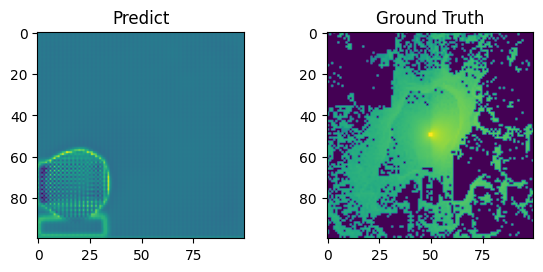

Loss: 0.232324


In [34]:
import argparse
import logging
import os

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from utils.data_loading_rt import RTDataset
from unet.unet_model_rt import UNet
from utils.utils import plot_img_and_mask

import matplotlib.pyplot as plt

building_height_map_dir = os.path.abspath('../res/Bl_building_npy')
terrain_height_map_dir = os.path.abspath('../res/Bl_terrain_npy')
ground_truth_signal_strength_map_dir = os.path.abspath('./coverage_maps_building_map_test_Jun27_before_vegas_proprocessed')

in_files = ["0_ca290c79-7674-471b-85df-d24c59f989e7.npy"]

net = UNet(n_channels=2, n_classes=1, bilinear=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# logging.info(f'Loading model {args.model}')
logging.info(f'Using device {device}')
net.to(device=device)

state_dict = torch.load("/Users/test/PycharmProjects/3DPathLoss/nc_raytracing/Pytorch-UNet-master/checkpoints/checkpoint_epoch2.pth", map_location=device)
net.load_state_dict(state_dict)

logging.info('Model loaded!')

for i, filename in enumerate(in_files):
    logging.info(f'Predicting image {filename} ...')

    building_img = np.load(os.path.join(building_height_map_dir,filename))[40:1040,40:1040]
    terrain_img = np.load(os.path.join(terrain_height_map_dir,filename))[40:1040,40:1040]
    combined_input = np.zeros((1,2, building_img.shape[0], terrain_img.shape[1]))
    combined_input[0,0,:, :] = building_img  # Assign first channel data
    combined_input[0,1,:, :] = terrain_img  # Assign second channel data

    net.eval()

    img = torch.from_numpy(combined_input)
    #img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)
    with torch.no_grad():
        output = net(img).cpu()

    ground_truth = np.load(os.path.join(ground_truth_signal_strength_map_dir,filename))
    output = output.cpu().numpy()

    output = np.array(output[0,0,:,:])

    print(output)
    print(ground_truth)

    import torch.nn as nn



    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2)

    # Plot the first image in the left subplot
    axes[0].imshow(output)
    axes[0].set_title('Predict')

    # Plot the second image in the right subplot
    axes[1].imshow(ground_truth)
    axes[1].set_title('Ground Truth')

    # Set spacing between subplots
    plt.subplots_adjust(wspace=0.4)

    # Display the figure
    plt.show()
    criterion = nn.MSELoss()



    loss = criterion(torch.from_numpy(output), torch.from_numpy(ground_truth))
    print("Loss: %f"%loss)


    # if not args.no_save:
    #     out_filename = out_files[i]
    #     result = mask_to_image(mask, mask_values)
    #     result.save(out_filename)
    #     logging.info(f'Mask saved to {out_filename}')
    #
    # if args.viz:
    #     logging.info(f'Visualizing results for image {filename}, close to continue...')
    #     plot_img_and_mask(img, mask)

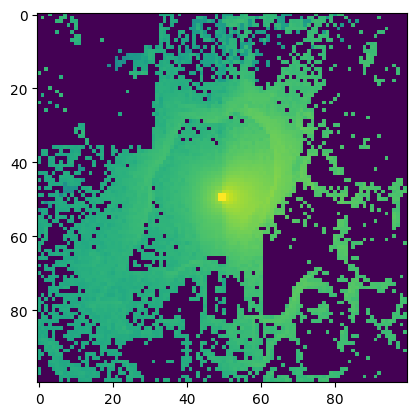